In [1]:
# -------------------------------------------------------
# 
# prepare data for the multi-panel |d18| response to 
# spatial hydroclimate change figure
# 
# [panel 1]: RTM (need input file from R)
# [panel 2]: paleo case study attenuation mod
# [panel 3]: seasonal cycle, iCESM
# 
# -------------------------------------------------------
import os
import numpy as np
import xarray as xr
import math
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.integrate
from scipy.interpolate import griddata  # for re-gridding np arrays in tau-bar fxn
from matplotlib import gridspec
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
# for colors
import cmocean
import cmocean.cm as cmo
import seaborn as sns # used for discrete

In [2]:
# [1] SEASONAL CYCLE --- read in data -----------------------------------
# read in anomaly results
datpath = "/DISTRIBUTE/data_and_analysis/iCESM_topotrack_seasonal"  # [CHANGE!] to correct path
fn_szn = "slice_sznAnom_jja-djf_upwindCrossover.nc"
ds_sznAnom = xr.open_dataset(os.path.join(datpath, fn_szn))

# read in seasonal results and merge
fnsuff = ["_ds_withDd18.nc", "_streamlines.csv"]
mos = ["jja", "djf"]
pref = "slice_"

ds1_open = pref + mos[0] + fnsuff[0]
ds1 = xr.open_dataset(os.path.join(datpath, ds1_open))
ds1 = ds1.expand_dims(dim='yr_slice')

df1_open = pref + mos[0] + fnsuff[1]
df1 = pd.read_csv(os.path.join(datpath, df1_open))
df1['yr_slice'] = mos[0]

ds2_open = pref + mos[1] + fnsuff[0]
ds2 = xr.open_dataset(os.path.join(datpath, ds2_open))
ds2 = ds2.expand_dims(dim='yr_slice')

df2_open = pref + mos[1] + fnsuff[1]
df2 = pd.read_csv(os.path.join(datpath, df2_open))
df2['yr_slice'] = mos[1]

# bring together
ds = xr.merge([ds1, ds2])
df = pd.concat([df1, df2])

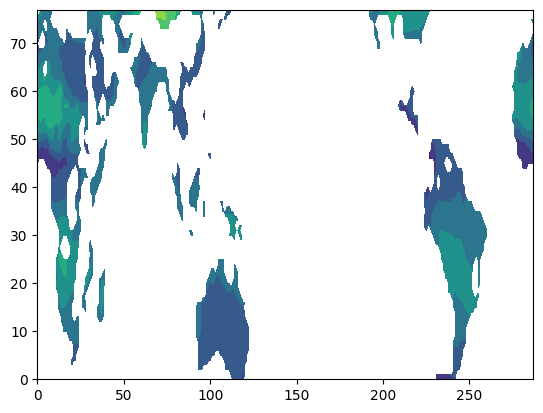

In [3]:
# [1] SEASONAL CYCLE --- filter topo and ocean
# ... select Dd18O range to consider
Dd18_var = "Dd18O_1000"
d18Cross_var = "Dd18_upwind_crossover"
d18_anom = "PRECT_d18O"
P_anom = "PRECT"
Dtopo_var = "Dtopo_1000"
# ... precip threshold
precip_threshold = 2.5e-8     # 2.5e-8 is ~770 mm/yr

# ... set ylims
minlat, maxlat = -35, 35

# ... filter out topo 
# define hatching condition
hatch_above = 500
hatching_condition_1 = np.abs(ds[Dtopo_var].sel(yr_slice='jja', lat=slice(minlat-2,maxlat+2))) > hatch_above
hatching_condition_2 = np.abs(ds[Dtopo_var].sel(yr_slice='djf', lat=slice(minlat-2,maxlat+2))) > hatch_above
hatching_condition_topo = hatching_condition_1 | hatching_condition_2   # sites where hatch_above in jja or djf

# ... filter out land
hatching_condition = hatching_condition_topo | (ds['LANDFRAC'].sel(yr_slice='jja', lat=slice(minlat-2,maxlat+2)) < 0.7)


# remove topo 
da_Dd18_anom = np.where(hatching_condition, np.nan, ds_sznAnom[Dd18_var].sel(lat=slice(minlat-2,maxlat+2)))
da_d18Cross = np.where(hatching_condition, np.nan, ds_sznAnom[d18Cross_var].sel(lat=slice(minlat-2,maxlat+2)))
da_d18_anom = np.where(hatching_condition, np.nan, ds_sznAnom[d18_anom].sel(lat=slice(minlat-2,maxlat+2)))
da_P_anom = np.where(hatching_condition, np.nan, ds_sznAnom[P_anom].sel(lat=slice(minlat-2,maxlat+2)))

plt.contourf(da_d18_anom)

In [4]:
# [1] SEASONAL CYCLE --- pull out places where amt eff works
amtEff_condition = da_P_anom / da_d18_anom < 0
da_P_anom_ae = np.where(amtEff_condition, da_P_anom, np.nan)
da_d18_anom_ae = np.where(amtEff_condition, da_d18_anom, np.nan)
da_d18Cross_ae = np.where(amtEff_condition, da_d18Cross, np.nan)
da_Dd18_anom_ae = np.where(amtEff_condition, da_Dd18_anom, np.nan)

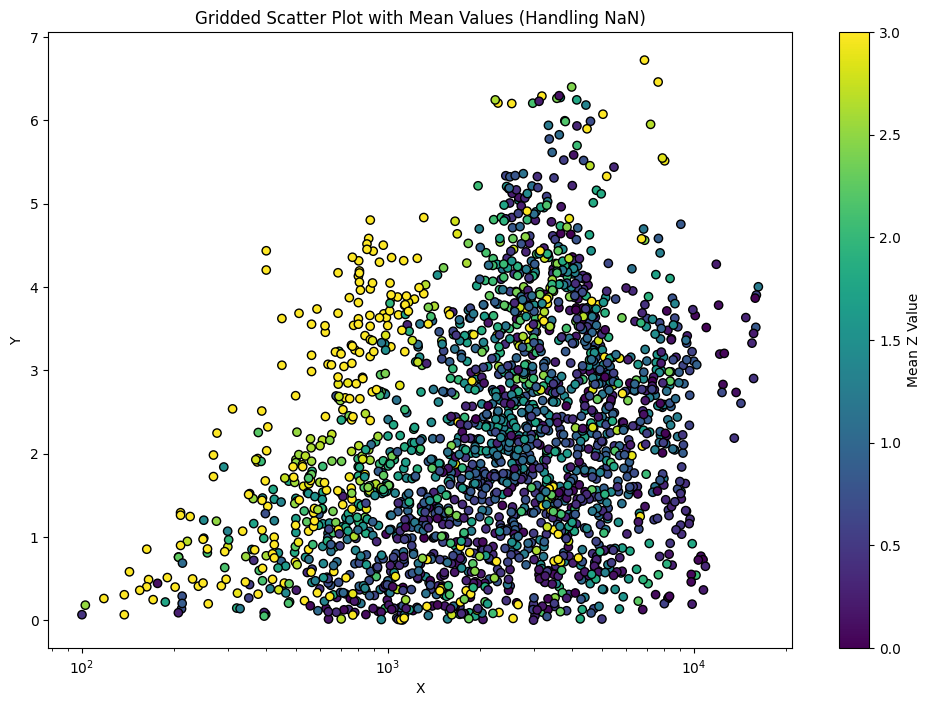

In [5]:
# [1] SEASONAL CYCLE --- quick plot
plt.figure(figsize=(12,8))
# Create a scatter plot of the original points
plt.scatter(da_d18Cross_ae, np.abs(da_d18_anom_ae), c=np.abs(da_Dd18_anom_ae), cmap='viridis', edgecolors='k', vmin=0, vmax=3)
# Create a gridded plot with the mean values
plt.colorbar(label='Mean Z Value')
plt.xlabel('X')
plt.xscale('log')
# plt.ylim(0,4)
plt.ylabel('Y')
plt.title('Gridded Scatter Plot with Mean Values (Handling NaN)')
plt.show()

In [10]:
# [1] SEASONAL CYCLE --- SAVE RESULT
szn_saveDir = "/anom_v_distance/icesmdat"    # [CHANGE!] to correct path
# w/ amt eff
np.save(os.path.join(szn_saveDir, "d18Cross_ae"), da_d18Cross_ae)
np.save(os.path.join(szn_saveDir, "d18_anom_ae"), da_d18_anom_ae)
np.save(os.path.join(szn_saveDir, "Dd18_anom_ae"), da_Dd18_anom_ae)
# no amt eff constraint
np.save(os.path.join(szn_saveDir, "d18Cross"), da_d18Cross)
np.save(os.path.join(szn_saveDir, "d18_anom"), da_d18_anom)
np.save(os.path.join(szn_saveDir, "Dd18_anom"), da_Dd18_anom)
# ----------------------------------------

In [6]:
# [2] --- PALEO EXAMPLE --- read in data --------------------------------
fn_218GS = '733hiRes_218ka_367ppm_darkSah_baseline'
maindir = '/DISTRIBUTE/data_and_analysis'  # [CHANGE!] to correct path
clim_fn_218GS = os.path.join(maindir, fn_218GS, "results", fn_218GS + "_CLIM.nc")
Dd18_dir = '/DISTRIBUTE/data_and_analysis/anom_v_distance'   # [CHANGE!] to correct path
Dd18_fn = 'slice_hiRes_timeAnom_attenMod_218gs-v-ctrl_upwindCrossover.nc'
# climate ncdf
ds218gs = xr.open_dataset(os.path.join(maindir, clim_fn_218GS)) 
# Dd18_anom file
ds218gs_Dd18Anom = xr.open_dataset(os.path.join(Dd18_dir, Dd18_fn))
# print clim
ds218gs

<xarray.Dataset>
Dimensions:                                  (lon: 144, lat: 96, time: 2,
                                              yr_slice: 2)
Coordinates:
  * lon                                      (lon) float64 0.0 2.5 ... 357.5
  * lat                                      (lat) float64 -90.0 -88.11 ... 90.0
  * time                                     (time) float64 0.0 1.0
  * yr_slice                                 (yr_slice) <U5 'mjjas' 'ndjfm'
Data variables: (12/39)
    SOLIN                                    (yr_slice, time, lat, lon) float32 ...
    FSDSC                                    (yr_slice, time, lat, lon) float32 ...
    FSNSC                                    (yr_slice, time, lat, lon) float32 ...
    albedo_clr_surf                          (yr_slice, time, lat, lon) float32 ...
    PRECT                                    (yr_slice, time, lat, lon) float32 ...
    ET                                       (yr_slice, time, lat, lon) float32 ...
    ...                                       ...
    Esource_frac_land                        (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_localEffect_upwind_l750         (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_regEffect_upwind_g750           (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_localRegional_upwind_effectSum  (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_distTo66perc_upwind             (yr_slice, lat, lon, time) float64 ...
    Dtau_bar                                 (yr_slice, lat, lon, time) float64 ...

In [7]:
# [2] PALEO EXAMPLE --- compute 18O and pr wtd mean
# --- compute d18O
#     oxygen isotopes are highly correlated with our tau-bar (water vapor attenuation)
#     variable. We adapt the correlation relationship of Siler et al. (in prep)
tau_d18_scale = -10   # slope of taubar vs d18O
tau_d18_intercept = 3 # y-intercept
# apply regression
ds218gs['d18O_est'] = ds218gs['tau_bar'] * tau_d18_scale + tau_d18_intercept
# and to the Dtau (just Dtau * slope)
ds218gs['Dd18O_est'] = ds218gs['Dtau_bar'] * tau_d18_scale 

# --- compute weighted mean 
#     (this cell may take a couple minutes to run if ds_clim is a big file)
# 218gs -- get precip-weighted mean
wts = ds218gs['PRECT'] / ds218gs['PRECT'].sum(dim='yr_slice')
wtd_avg_ds = (ds218gs * wts).sum(dim='yr_slice')
new_timeslice = wtd_avg_ds.expand_dims(yr_slice=['ann_prWtd'])
ds218gs = xr.concat([ds218gs, new_timeslice], dim='yr_slice')

In [8]:
# [2] PALEO EXAMPLE --- filter out ocean and topo
# pull out just the data we want
tds = ds218gs.sel(time = 1, yr_slice = "ann_prWtd")
tds['Dd18O_1000'] = ds218gs_Dd18Anom['Dd18O_1000']

# --- interpolate hatching condition to paleo ds
hatch_paleo = hatching_condition.astype('int').interp(lon=ds218gs.lon, lat=ds218gs.lat)
hatch_paleo2 = hatch_paleo.sel(lat=slice(minlat-2,maxlat+2))
# --- define vars
tau_totEffect = 'Dtau_bar'
tau_dist = 'Dtau_bar_distTo66perc_upwind'
grad_effect = 'Dd18O_1000'

# get arrays
da_paleo_Dd18 = np.where(hatch_paleo2, np.nan, tds[tau_totEffect].sel(lat=slice(minlat-2,maxlat+2))*tau_d18_scale)
da_paleo_dist = np.where(hatch_paleo2, np.nan, tds[tau_dist].sel(lat=slice(minlat-2,maxlat+2)))
da_paleo_Dd18Oanom = np.where(hatch_paleo2, np.nan, tds[grad_effect].sel(lat=slice(minlat-2, maxlat+2)))

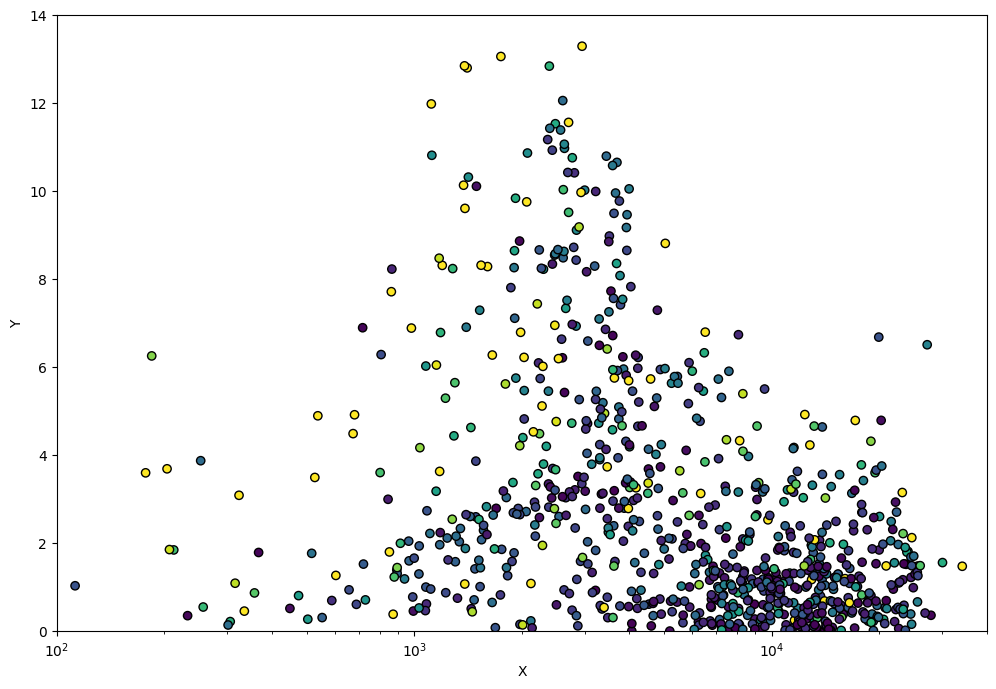

In [9]:
# [2] PALEO EXAMPLE --- quick plot
plt.figure(figsize=(12,8))
# Create a scatter plot of the original points
plt.scatter(da_paleo_dist, np.abs(da_paleo_Dd18), c=np.abs(da_paleo_Dd18Oanom),
            edgecolors='k', vmin=0, vmax=3)
# Create a gridded plot with the mean values
plt.xlabel('X')
plt.xscale('log')
plt.xlim(1e2,4e4)
plt.ylim(0,14)
plt.ylabel('Y')
plt.show()

In [10]:
# [2] PALEO EXAMPLE --- SAVE RESULT
paleo_saveDir = "/anom_v_distance/paleodat"    # [CHANGE!] to correct path
# save
np.save(os.path.join(paleo_saveDir, "paleo_dist"), da_paleo_dist)
np.save(os.path.join(paleo_saveDir, "paleo_Dtau"), da_paleo_Dd18)
np.save(os.path.join(paleo_saveDir, "paleo_Dslope"), da_paleo_Dd18Oanom)
# ----------------------------------------

In [10]:
# [3] RTM EXAMPLE --- read in data -------------------------------
rtmpath = "/DISTRIBUTE/data_and_analysis/rtm"     # [CHANGE!] to correct path
rtmfn = "upwindM_change_results_largerDd18.csv"
dfrtm = pd.read_csv(os.path.join(rtmpath, rtmfn))
dfrtm

,Unnamed: 0,upwind_dist_km,site_Dd18O,site_DW,dist_inland_km,site_region
0,1,-2900.000000,-0.000415,-0.000056,100,coast
1,2,-1500.000000,-0.006917,-0.004612,1500,middle
2,3,0.000000,0.145351,0.508063,3000,inland
3,4,-2821.444065,0.000507,0.000077,100,coast
4,5,-1421.444065,0.008460,0.006313,1500,middle
...,...,...,...,...,...,...
295,296,32246.565511,-0.170011,-16.416320,1500,middle
296,297,33746.565511,-0.286614,-16.369247,3000,inland
297,298,47100.000000,-0.007991,-16.438456,100,coast
298,299,48500.000000,-0.166310,-16.416321,1500,middle


In [17]:
# [3] RTM EXAMPLE --- SAVE RESULT
rtm_saveDir = "anom_v_distance/rtmdat"  # [CHANGE!] to correct path
# save
dfrtm.to_csv(os.path.join(rtm_saveDir, "rtm_df.csv"))
# ----------------------------------------